# Flu Shot Learning: Predict H1N1 and Seasonal Flu Vaccines
## Random Forest

## Introduction
**Research Question: Can you predict whether people got H1N1 and seasonal flu vaccines using information they shared about their backgrounds, opinions, and health behaviors?**

In this challenge, we will take a look at vaccination, a key public health measure used to fight infectious diseases. Vaccines provide immunization for individuals, and enough immunization in a community can further reduce the spread of diseases through "herd immunity."


Our goal is to predict how likely individuals are to receive their H1N1 and seasonal flu vaccines. Specifically, we'll be predicting two probabilities: one for `h1n1_vaccine` and one for `seasonal_vaccine`.

## About the Data
A vaccine for the H1N1 flu virus became publicly available in October 2009. In late 2009 and early 2010, the United States conducted the National 2009 H1N1 Flu Survey. This phone survey asked respondents whether they had received the H1N1 and seasonal flu vaccines, in conjunction with questions about themselves. These additional questions covered their social, economic, and demographic background, opinions on risks of illness and vaccine effectiveness, and behaviors towards mitigating transmission. A better understanding of how these characteristics are associated with personal vaccination patterns can provide guidance for future public health efforts.

Each row in the dataset represents one person who responded to the National 2009 H1N1 Flu Survey. The dataset includes **35 features**.

For this competition, there are two target variables:

* `h1n1_vaccine` - Whether respondent received H1N1 flu vaccine.
* `seasonal_vaccine` - Whether respondent received seasonal flu vaccine.

Both are binary variables: 0 = No; 1 = Yes. Some respondents didn't get either vaccine, others got only one, and some got both. This is formulated as a multilabel (and not multiclass) problem.

## Helper Functions

In [1]:
def confusion_matrix_plot(conf_matrix, normalize=False, title='Confusion Matrix'):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """  
    if normalize:
        title = 'Normalized Confusion Matrix'
        conf_matrix = np.round(conf_matrix / conf_matrix.sum(axis=1), 2)
        
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(title)

    plt.tight_layout()
    plt.show()

In [2]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Cross Validation Performance", fontsize=15)
    ax.set_xlabel(name_param_1, fontsize=12)
    ax.set_ylabel('CV Average F1 Score', fontsize=12)
    ax.legend(loc="best", fontsize=10)
    ax.grid('on')

## Load Packages & Data

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from tensorflow import keras
from keras import metrics

In [4]:
data = pd.read_csv("data/training_set_features.csv")
target = pd.read_csv("data/training_set_labels.csv")

In [5]:
joined_df = data.join(target[['h1n1_vaccine', 'seasonal_vaccine']])
print(joined_df.shape)
joined_df.head()

(26707, 38)


,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Explore Data

In [6]:
print('Number of zeros:', joined_df[joined_df.seasonal_vaccine == 0].seasonal_vaccine.count())
print('Number of ones:', joined_df[joined_df.seasonal_vaccine == 1].seasonal_vaccine.count())

Number of zeros: 14272
Number of ones: 12435


In [7]:
# How many NAs?
joined_df.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
m

In [8]:
joined_df.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,...,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,...,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,...,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,...,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,...,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,1.000000,1.000000


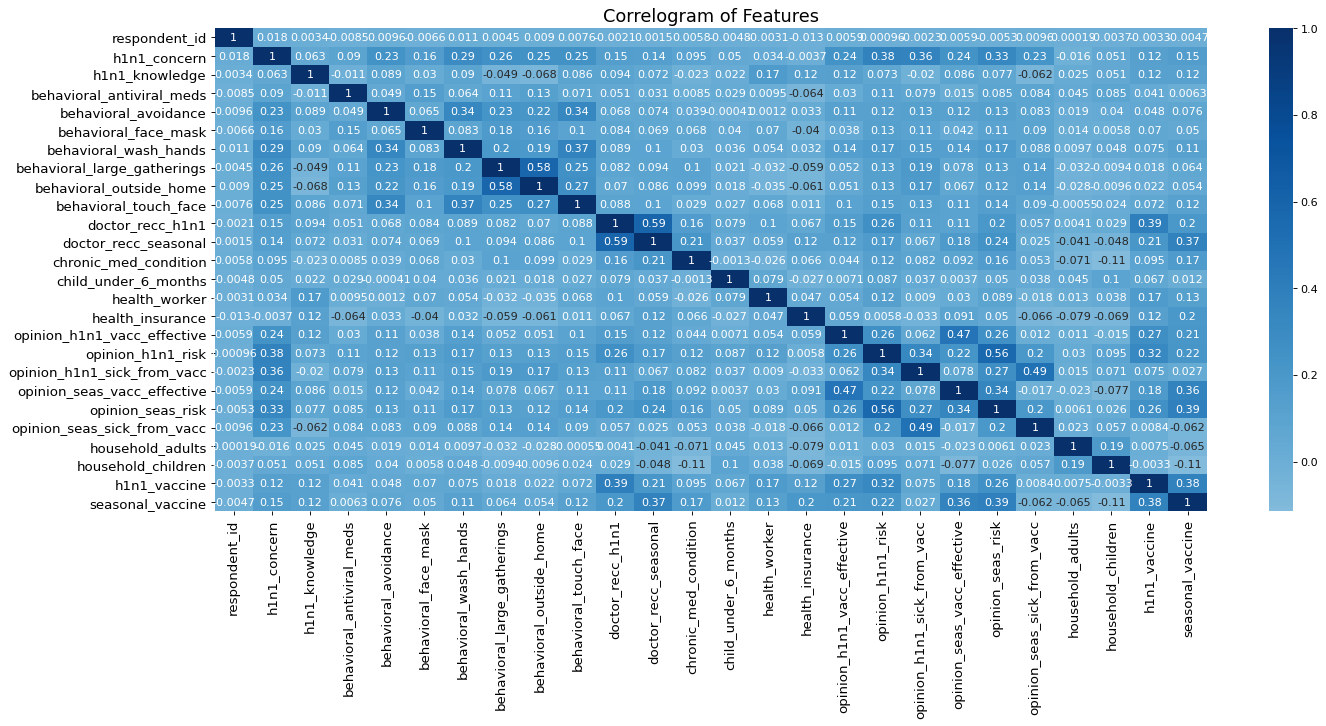

In [9]:
plt.figure(figsize=(20,8), dpi= 80)
sns.heatmap(joined_df.corr(), xticklabels=joined_df.corr().columns, yticklabels=joined_df.corr().columns, cmap='Blues', center=0, annot=True)

# Decorations
plt.title('Correlogram of Features', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Looking at the correlation between features and our target `seasonal_vaccine`, we can observe our top 10 most correlated features:
1. opinion_seas_risk - 0.39
2. h1n1_vaccine - 0.38 (however, this is the other target variable)
3. doctor_recc_seasonal - 0.37
4. opinion_seas_vacc_effective - 0.36
5. opinion_h1n1_risk - 0.22
6. opinion_h1n1_vacc_effective - 0.21
7. health_insurance - 0.2
8. doctor_recc_h1n1 - 0.2
9. chronic_med_condition - 0.17
10. h1n1_concern - 0.15
11. health_worker - 0.13

## Feature Engineering

### Pre-Split Feature Engineering

In [10]:
# One-Hot Encoding
age_group_one_hot = pd.get_dummies(joined_df['age_group'])
education_one_hot = pd.get_dummies(joined_df['education'])
race_one_hot = pd.get_dummies(joined_df['race'])
sex_one_hot = pd.get_dummies(joined_df['sex'])
income_poverty_one_hot = pd.get_dummies(joined_df['income_poverty'])
marital_status_one_hot = pd.get_dummies(joined_df['marital_status'])
rent_or_own_one_hot = pd.get_dummies(joined_df['rent_or_own'])
employment_status_one_hot = pd.get_dummies(joined_df['employment_status'])
hhs_geo_region_one_hot = pd.get_dummies(joined_df['hhs_geo_region']).rename(lambda column: f'region_{column}', axis=1)
census_msa_one_hot = pd.get_dummies(joined_df['census_msa'])
employment_industry_one_hot = pd.get_dummies(joined_df['employment_industry']).rename(lambda column: f'industry_{column}', axis=1)
employment_occupation_one_hot = pd.get_dummies(joined_df['employment_occupation']).rename(lambda column: f'occupation_{column}', axis=1)

In [11]:
one_hot_joined_df = joined_df.join([age_group_one_hot, education_one_hot, race_one_hot, sex_one_hot, 
                            income_poverty_one_hot, marital_status_one_hot, rent_or_own_one_hot,
                            employment_status_one_hot, hhs_geo_region_one_hot, census_msa_one_hot,
                            employment_industry_one_hot, employment_occupation_one_hot])

In [12]:
# Top 28 features
features = ['opinion_seas_vacc_effective', 'opinion_seas_risk', '65+ Years', 'doctor_recc_seasonal',
           'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'h1n1_concern', 'h1n1_knowledge', 'health_insurance',
           '18 - 34 Years', 'opinion_seas_sick_from_vacc', 'household_children', 'doctor_recc_h1n1',
           'opinion_h1n1_sick_from_vacc', 'household_adults', 'chronic_med_condition', 'Not in Labor Force',
           'White', 'Employed', 'College Graduate', 'Rent', 'behavioral_touch_face', '55 - 64 Years', 'Female', 
           'Male', 'MSA, Not Principle  City', 'behavioral_outside_home', 'Own']


target = ['seasonal_vaccine']
df = one_hot_joined_df[features + target]

In [13]:
### Remove NAs
print('Old number of rows:', df.shape[0])
print('Number of NAs removed:', sum([True for idx,row in df.iterrows() if any(row.isnull())]))
df = df.dropna()
print('New number of rows:', df.shape[0])

Old number of rows: 26707
Number of NAs removed: 13042
New number of rows: 13665


### Train-Test Split

In [14]:
### Train test split
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2,
                                                    random_state=42)

print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (10932, 28)
y_train.shape: (10932, 1)
X_test.shape: (2733, 28)
y_test.shape: (2733, 1)


### Post-Split Feature Engineering

In [15]:
### Data Balancing 
# Looks like not needed
train = X_train.join(y_train[['seasonal_vaccine']])
train.groupby(['seasonal_vaccine']).size()

seasonal_vaccine
0    5407
1    5525
dtype: int64

In [16]:
### Scale & fit features
scaler = StandardScaler()
scaler_model = scaler.fit(X_train)
X_train = scaler_model.transform(X_train)
X_test = scaler_model.transform(X_test)

## Hyperparameter tuning

In [17]:
n_estimators = [50, 60, 80, 100, 120]
max_depth = [5, 8, 10, 12, 14]
param_grid = {'n_estimators': n_estimators,
              'max_depth': max_depth}

In [18]:
np.random.seed(1001)

clf = RandomForestClassifier(random_state=1001)

In [19]:
from sklearn.model_selection import GridSearchCV

grid_clf = GridSearchCV(clf, param_grid, cv=10, scoring='f1')
grid_clf.fit(X_train, y_train)

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_valida

GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1001),
             param_grid={'max_depth': [5, 8, 10, 12, 14],
                         'n_estimators': [50, 60, 80, 100, 120]},
             scoring='f1')

In [20]:
grid_clf.best_params_

{'max_depth': 12, 'n_estimators': 50}

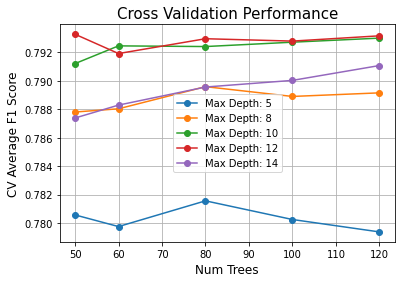

In [21]:
plot_grid_search(grid_clf.cv_results_, n_estimators, max_depth, 'Num Trees', 'Max Depth')

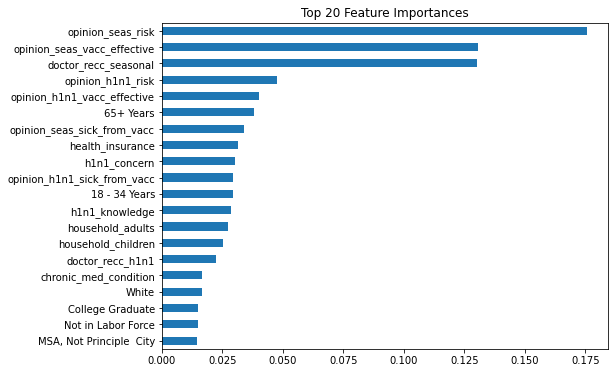

In [22]:
feature_importance = pd.Series(grid_clf.best_estimator_.feature_importances_, index = features).sort_values(ascending = False)
top_20_fi = feature_importance.nlargest(20).sort_values(ascending=True)

plt.figure(figsize=(8, 6))
top_20_fi.plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

In [23]:
# Predict on train and test
train_predictions = grid_clf.predict(X_train)
test_predictions = grid_clf.predict(X_test)

## Evaluation

In [24]:
# Compare the first 10 predictions
train_compare = y_train.copy()
train_compare['prediction'] = train_predictions
train_compare.rename(columns={"seasonal_vaccine": "label"}, inplace=True)
train_compare.head(10)

,label,prediction
868,0,0
26034,1,1
16344,1,1
19452,1,0
1039,1,1
12724,1,1
9152,0,0
18951,0,0
17307,1,1
25844,0,0


### Train Evaluation

In [25]:
print('Area Under ROC:', round(roc_auc_score(y_train, train_predictions), 4))
print('Accuracy:', round(accuracy_score(y_train, train_predictions), 4))
print('Precision:', round(precision_score(y_train, train_predictions), 4))
print('Recall:', round(recall_score(y_train, train_predictions), 4))
print('F1 Score:', round(f1_score(y_train, train_predictions), 4))

Area Under ROC: 0.9022
Accuracy: 0.9021
Precision: 0.9094
Recall: 0.8956
F1 Score: 0.9024


### Test Evaluation

In [26]:
print('Area Under ROC:', round(roc_auc_score(y_test, test_predictions), 4))
print('Accuracy:', round(accuracy_score(y_test, test_predictions), 4))
print('Precision:', round(precision_score(y_test, test_predictions), 4))
print('Recall:', round(recall_score(y_test, test_predictions), 4))
print('F1 Score:', round(f1_score(y_test, test_predictions), 4))

Area Under ROC: 0.7947
Accuracy: 0.7947
Precision: 0.7931
Recall: 0.7925
F1 Score: 0.7928


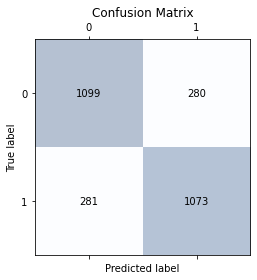

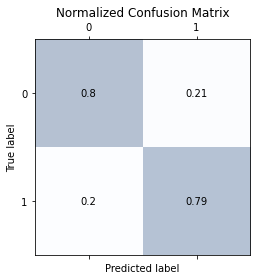

In [27]:
conf_matrix = tf.math.confusion_matrix(
    y_test,
    test_predictions.flatten(),
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

confusion_matrix_plot(conf_matrix.numpy())
confusion_matrix_plot(conf_matrix.numpy(), normalize=True)

## Final Random Forest Model

In [28]:
clf = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=1234)

# Fit model
clf.fit(X_train, y_train)

/Users/yasmine/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(max_depth=10, random_state=1234)

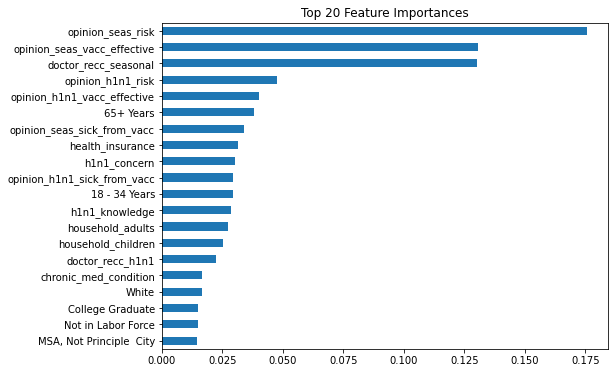

In [29]:
feature_importance = pd.Series(grid_clf.best_estimator_.feature_importances_, index = features).sort_values(ascending = False)
top_20_fi = feature_importance.nlargest(20).sort_values(ascending=True)


plt.figure(figsize=(8, 6))
top_20_fi.plot(kind='barh')
plt.title("Top 20 Feature Importances")
plt.show()

In [30]:
# Predict on train and test
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

## Evaluation

In [31]:
# Compare the first 10 predictions
train_compare = y_train.copy()
train_compare['prediction'] = train_predictions
train_compare.rename(columns={"seasonal_vaccine": "label"}, inplace=True)
train_compare.head(10)

,label,prediction
868,0,1
26034,1,1
16344,1,1
19452,1,0
1039,1,1
12724,1,1
9152,0,1
18951,0,0
17307,1,0
25844,0,0


### Train Evaluation

In [32]:
print('Area Under ROC:', round(roc_auc_score(y_train, train_predictions), 4))
print('Accuracy:', round(accuracy_score(y_train, train_predictions), 4))
print('Precision:', round(precision_score(y_train, train_predictions), 4))
print('Recall:', round(recall_score(y_train, train_predictions), 4))
print('F1 Score:', round(f1_score(y_train, train_predictions), 4))

Area Under ROC: 0.8603
Accuracy: 0.8602
Precision: 0.8684
Recall: 0.8527
F1 Score: 0.8605


### Test Evaluation

In [33]:
print('Area Under ROC:', round(roc_auc_score(y_test, test_predictions), 4))
print('Accuracy:', round(accuracy_score(y_test, test_predictions), 4))
print('Precision:', round(precision_score(y_test, test_predictions), 4))
print('Recall:', round(recall_score(y_test, test_predictions), 4))
print('F1 Score:', round(f1_score(y_test, test_predictions), 4))

Area Under ROC: 0.802
Accuracy: 0.802
Precision: 0.8031
Recall: 0.7954
F1 Score: 0.7993


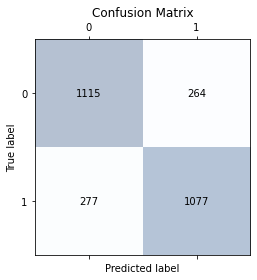

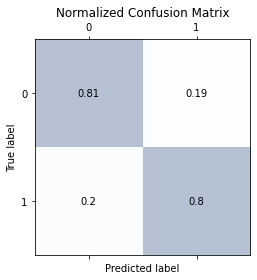

In [34]:
conf_matrix = tf.math.confusion_matrix(
    y_test,
    test_predictions.flatten(),
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)
conf_matrix

confusion_matrix_plot(conf_matrix.numpy())
confusion_matrix_plot(conf_matrix.numpy(), normalize=True)